In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
from sklearn.preprocessing import MinMaxScaler
import os, glob, inspect, sys
import re

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import epri_mc_lib_2 as mc
from importlib import reload
reload(mc)

<module 'epri_mc_lib_2' from '/home/nick/Bureau/Programming/S2DS/Oct20_EPRI/Task2/NB/epri_mc_lib_2.py'>

In [2]:
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
# Define basic features importances:
def get_feature_importance(name, model, feature_names):
    '''return classical feature importances
    Args:
        -name:str
        -model: trained model
    return importance as a df    
    '''
    if name == 'Ridge' or name == 'Elastic' or name == 'Lasso':
        importance = model.coef_
        importance_df = pd.DataFrame(importance.T, columns=[name], index=feature_names)
        importance_df.sort_values(name, ascending=True, inplace=True)
       
    if name == 'KNN' or name == 'SVM':
        pass
        
    if name == 'RF' or name == 'Tree': 
        importance = model.feature_importances_
        rel_importance = 100.0 * (importance / importance.sum())
        importance_df = pd.DataFrame(rel_importance.T, columns=[name], index=feature_names)
        importance_df.sort_values(name, ascending=True, inplace=True)
 
    if name == 'XGB':
        importance = model.feature_importances_
        rel_importance = 100.0 * (importance / importance.sum())
        importance_df = pd.DataFrame(rel_importance.T, columns=['XGB'], index=feature_names)
        importance_df.sort_values('XGB', ascending=True, inplace=True)
         
    return importance_df

### Import data and merge replicates

In [4]:
merged_simulated = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), '../Data/Merged_data/CopulaGAN_simulated_data_up.csv'),
                    index_col=0)
merged_simulated

,MS_Avg,MS_neg_error,MS_pos_error,TEP_average,TEP_error,Beta_avg,IF_amp_2.25MHz,SE_IF_2.25MHz,SE_%_IF_2.25MHz,IF_amp_3.5MHz,SE_IF_3.5MHz,SE_%_IF_3.5MHz,BS_amp,type_cw
KJIC,,,,,,,,,,,,,,
104.509264,1.065855,0.327941,0.389267,-1.381644,0.053704,0.001991,0.834178,0.020991,3.214580,0.572778,0.014074,1.923546,7.903716,304-40
121.243211,0.527884,0.072630,0.192897,-1.338246,0.049170,0.002014,0.790009,0.017016,3.217831,0.514249,0.013415,2.044493,9.467436,304-40
79.715363,0.043292,0.034634,0.024251,-1.726655,0.044679,0.002272,0.905257,0.014341,1.586630,0.889712,0.017395,0.941155,4.245708,316-60
64.051840,0.019697,0.028520,0.011775,-1.617859,0.045108,0.002848,0.743794,0.024531,4.418423,0.568634,0.004623,0.690947,13.192833,316-20
73.157311,1.674169,0.706512,0.975727,-1.163593,0.050287,0.002355,0.936776,0.030000,4.412032,0.734233,0.014353,2.847758,10.842438,347-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103.656045,0.903747,0.293774,0.663192,-1.366847,0.050597,0.001837,0.793925,0.012903,2.922287,0.534626,0.016181,2.236833,8.944160,304-40
73.563492,0.235263,0.121622,0.337979,-1.323185,0.051098,0.002270,0.905553,0.006000,0.800004,0.816819,0.015096,2.161126,11.757315,347-40
195.852151,0.009489,0.002000,0.002000,-1.315298,0.044993,0.002295,0.188705,0.008758,4.360779,0.305240,0.003606,1.996722,8.618148,A286-0


## Select columns of interest

In [5]:
mean_df = merged_simulated.copy()
cw_regex = re.compile("[0-9]+$") 
cold_work = [str(re.search(cw_regex,x).group()) for x in mean_df.type_cw ]
mean_df['KJIC'] = mean_df.index
cw_regex = re.compile("^[A]*[0-9]+") 
mean_df.index = [str(re.search(cw_regex,x).group()) for x in mean_df.type_cw ]
mean_df = mean_df[["KJIC","MS_Avg","TEP_average","Beta_avg","IF_amp_2.25MHz","IF_amp_3.5MHz","BS_amp"]]
mean_df['log_MS_Avg'] = np.log(mean_df['MS_Avg'])
mean_df['log_beta_avg'] = np.log(mean_df['Beta_avg']) 
log_kjic = np.log(mean_df.KJIC)
mean_kjic = mean_df.KJIC
mean_df.drop(columns=['KJIC','MS_Avg','Beta_avg'], inplace=True)
mean_df

,TEP_average,IF_amp_2.25MHz,IF_amp_3.5MHz,BS_amp,log_MS_Avg,log_beta_avg
304,-1.381644,0.834178,0.572778,7.903716,0.063777,-6.219122
304,-1.338246,0.790009,0.514249,9.467436,-0.638879,-6.207786
316,-1.726655,0.905257,0.889712,4.245708,-3.139785,-6.087111
316,-1.617859,0.743794,0.568634,13.192833,-3.927307,-5.860981
347,-1.163593,0.936776,0.734233,10.842438,0.515317,-6.051243
...,...,...,...,...,...,...
304,-1.366847,0.793925,0.534626,8.944160,-0.101206,-6.299407
347,-1.323185,0.905553,0.816819,11.757315,-1.447049,-6.088029
A286,-1.315298,0.188705,0.305240,8.618148,-4.657654,-6.076902
316,-1.478194,0.475078,0.547826,9.722967,-3.848919,-6.069059


## Scale data

In [6]:
scaled_df = mc.scale_general(mean_df, MinMaxScaler())[0]
scaled_df.index = mean_df.index
#scaled_df["cold_work"] = cold_work
# The logarithmic of the KJIC is incorporated for better results
scaled_kjic = mc.scale_general(pd.DataFrame(mean_kjic), MinMaxScaler())[0]
scaled_kjic.index = mean_df.index
scaled_df['KJIC'] = scaled_kjic
scaled_df

,TEP_average,IF_amp_2.25MHz,IF_amp_3.5MHz,BS_amp,log_MS_Avg,log_beta_avg,KJIC
304,0.430602,0.399905,0.102356,0.391417,0.726047,0.313547,0.366670
304,0.470641,0.375614,0.089744,0.496761,0.618574,0.333589,0.454581
316,0.112296,0.438994,0.170650,0.144986,0.236057,0.546948,0.236416
316,0.212671,0.350199,0.101463,0.747732,0.115605,0.946759,0.154128
347,0.631776,0.456328,0.137147,0.589392,0.795110,0.610365,0.201964
...,...,...,...,...,...,...,...
304,0.444254,0.377768,0.094135,0.461510,0.700812,0.171598,0.362187
347,0.484536,0.439157,0.154943,0.651025,0.494963,0.545327,0.204097
A286,0.491813,0.044931,0.044707,0.439547,0.003897,0.564999,0.846535
316,0.341525,0.202420,0.096979,0.513976,0.127594,0.578865,0.404025


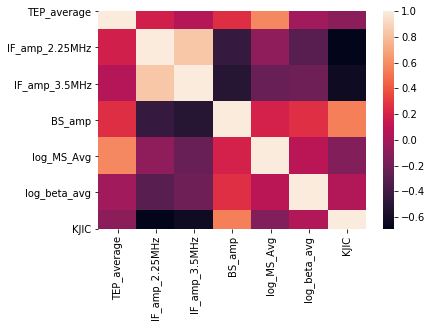

In [7]:
sns.heatmap(scaled_df.corr())

In [8]:
# Seperating data depending on the type of steel
SS_304=scaled_df[scaled_df.index == '304']
SS_316=scaled_df[scaled_df.index == '316']
SS_347=scaled_df[scaled_df.index == '347']
SS_A286=scaled_df[scaled_df.index == 'A286']

In [9]:
SS_list=["SS304","SS316","SS347","SSA286"]

## Linear Regression

In [10]:
def lr_sstype(scaled_df,name):
    # Creating Predictor variable 'X' and Target Variable 'y'
    # X contains all the features except for the target value Price
    X = scaled_df.drop('KJIC', axis = 1)
    y = scaled_df['KJIC']
    
    # Creating the training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=50)
    
    # X_train contains 70% of total dataset
    print("Training dataset:", X_train.shape)
    # X_test contains 30% of total dataset
    print("Test dataset:", X_test.shape)
    
    # Model Liner Regression
    lr = LinearRegression()
    
    #Train/fit the model to training data
    lr.fit(X_train,y_train)
    
    pred = lr.predict(X_test)
    
    # print the intercept
    print("Intercept:", lr.intercept_)
    
    #Coefficients
    coeff_df = pd.DataFrame(lr.coef_,X.columns,columns=['Coefficient'])
    print("Coefficients:", coeff_df)
    
    
    print("r2 score for training: ", r2_score(y_train, lr.predict(X_train)))
    print("r2 score for testing: ", r2_score(y_test, pred))
    
    print('MAE:', metrics.mean_absolute_error(y_test, pred))
    print('MSE:', metrics.mean_squared_error(y_test, pred))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred)))
    
    plt.scatter(y_test,pred)
    plt.title("Linear Regression of "+ name)
    plt.xlabel("Fracture Toughness")
    plt.ylabel("Predicted Fracture Toughness")
    
    return

Training dataset: (180, 6)
Test dataset: (78, 6)
Intercept: 0.768476031403504
Coefficients:                 Coefficient
TEP_average       -0.411230
IF_amp_2.25MHz    -0.449708
IF_amp_3.5MHz     -0.729692
BS_amp            -0.026244
log_MS_Avg         0.028551
log_beta_avg       0.125106
r2 score for training:  0.8008376485041219
r2 score for testing:  0.7564478311221073
MAE: 0.05501519443960387
MSE: 0.004794845410741298
RMSE: 0.06924482226665975


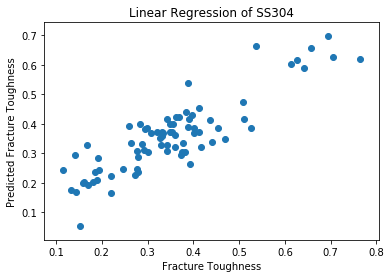

In [11]:
lr_sstype(SS_304,"SS304")

## Ridge Regression

In [12]:
def rr_sstype(scaled_df,name):
    # Creating Predictor variable 'X' and Target Variable 'y'
    # X contains all the features except for the target value Price
    X = scaled_df.drop('KJIC', axis = 1)
    y = scaled_df['KJIC']
    
    # Creating the training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=50)
    
    # X_train contains 70% of total dataset
    print("Training dataset:", X_train.shape)
    # X_test contains 30% of total dataset
    print("Test dataset:", X_test.shape)
    
    #Model Ridge Rigression
    rr = Ridge(alpha=0.01)
    rr.fit(X_train, y_train) 
    pred_train_rr= rr.predict(X_train)
    print("RMSE train:", np.sqrt(mean_squared_error(y_train,pred_train_rr)))
    print("r2 score for training: ", r2_score(y_train, pred_train_rr))
    
    pred_test_rr= rr.predict(X_test)
    print("RMSE test:", np.sqrt(mean_squared_error(y_test,pred_test_rr))) 
    print("r2 score for test: ", r2_score(y_test, pred_test_rr))
    
    plt.scatter(y_test,pred_test_rr)
    plt.plot([0, 1], [0, 1])
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title("Ridge Regression of "+ name)
    plt.xlabel("Fracture Toughness")
    plt.ylabel("Predicted Fracture Toughness")
    
    return

Training dataset: (180, 6)
Test dataset: (78, 6)
RMSE train: 0.07408129984936843
r2 score for training:  0.8007993914880915
RMSE test: 0.06918163738443098
r2 score for test:  0.756892103879834


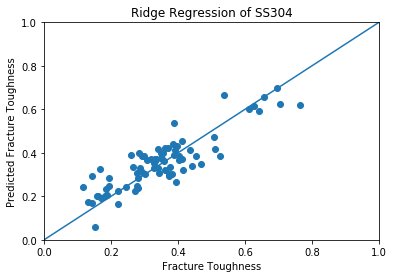

In [13]:
rr_sstype(SS_304,"SS304")

Training dataset: (185, 6)
Test dataset: (80, 6)
RMSE train: 0.06302445238439028
r2 score for training:  0.69146227721389
RMSE test: 0.0743765407619551
r2 score for test:  0.6623867342427681


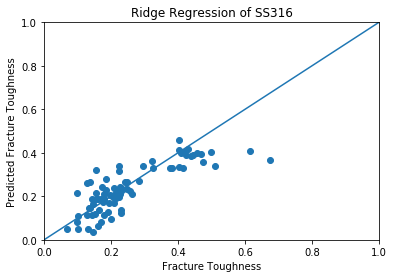

In [14]:
rr_sstype(SS_316,"SS316")

Training dataset: (181, 6)
Test dataset: (78, 6)
RMSE train: 0.07008357180712264
r2 score for training:  0.9225913350785682
RMSE test: 0.06880445808814241
r2 score for test:  0.932373944875531


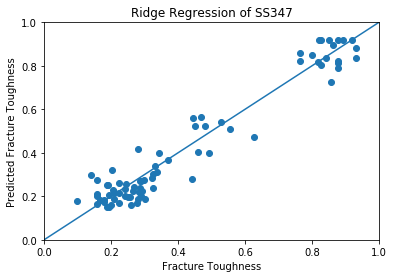

In [15]:
rr_sstype(SS_347,"SS347")

## Elastic net

In [16]:
def enet_sstype(scaled_df,name):
    # Creating Predictor variable 'X' and Target Variable 'y'
    # X contains all the features except for the target value Price
    X = scaled_df.drop('KJIC', axis = 1)
    y = scaled_df['KJIC']
    
    # Creating the training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=50)
    
    # X_train contains 70% of total dataset
    print("Training dataset:", X_train.shape)
    # X_test contains 30% of total dataset
    print("Test dataset:", X_test.shape)
    
    #Model Ridge Rigression
    model_enet = ElasticNet(alpha = 0.01)
    model_enet.fit(X_train, y_train) 
    pred_train_enet= model_enet.predict(X_train)
    print("RMSE train:", np.sqrt(mean_squared_error(y_train,pred_train_enet)))
    print("r2 score for training: ", r2_score(y_train, pred_train_enet))
    
    pred_test_enet= model_enet.predict(X_test)
    print("RMSE test:", np.sqrt(mean_squared_error(y_test,pred_test_enet)))
    print("r2 score for test: ", r2_score(y_test, pred_test_enet))
    
    plt.scatter(y_test,pred_test_enet)
    plt.plot([0, 1], [0, 1])
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title("Elastic Net Regression of "+ name)
    plt.xlabel("Fracture Toughness")
    plt.ylabel("Predicted Fracture Toughness")
    
    return

Training dataset: (180, 6)
Test dataset: (78, 6)
RMSE train: 0.09626502697689458
r2 score for training:  0.6636351959711494
RMSE test: 0.08154944416869228
r2 score for test:  0.6622001890308375


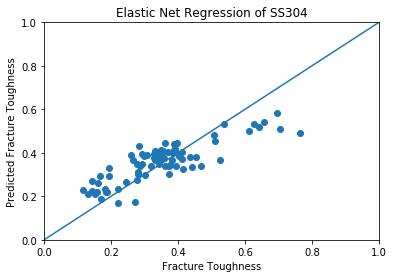

In [17]:
enet_sstype(SS_304,"SS304")

Training dataset: (185, 6)
Test dataset: (80, 6)
RMSE train: 0.10140916972518682
r2 score for training:  0.20118803338787494
RMSE test: 0.119421897014977
r2 score for test:  0.12960681254630513


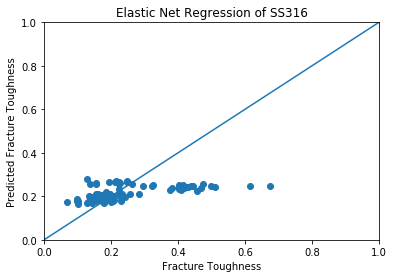

In [18]:
enet_sstype(SS_316,"SS316")

Training dataset: (181, 6)
Test dataset: (78, 6)
RMSE train: 0.09206011521781651
r2 score for training:  0.8664326989795254
RMSE test: 0.08941688584376091
r2 score for test:  0.8857858327033937


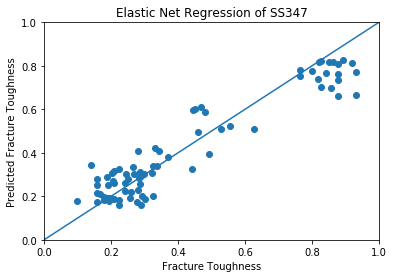

In [19]:
enet_sstype(SS_347,"SS347")

## Lasso 

In [38]:
def lasso_sstype(scaled_df,name, alpha):
    # Creating Predictor variable 'X' and Target Variable 'y'
    # X contains all the features except for the target value Price
    X = scaled_df.drop('KJIC', axis = 1)
    y = scaled_df['KJIC']
    
    # Creating the training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=50)
    
    print(name+", "+str(alpha))
    # X_train contains 70% of total dataset
    print("Training dataset:", X_train.shape)
    # X_test contains 30% of total dataset
    print("Test dataset:", X_test.shape)
    
    #Model LASSO Rigression
    model_lasso = Lasso(alpha=alpha)
    model_lasso.fit(X_train, y_train) 
    pred_train_lasso= model_lasso.predict(X_train)
    print()
    print("RMSE train:", np.sqrt(mean_squared_error(y_train,pred_train_lasso)))
    print("r2 score for train: ", r2_score(y_train, pred_train_lasso))
    
    pred_test_lasso= model_lasso.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test,pred_test_lasso))
    r2_test = r2_score(y_test, pred_test_lasso)
    print("RMSE test:", np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 
    print("r2 score for test: ", r2_score(y_test, pred_test_lasso))
    
    plt.figure()
    plt.scatter(y_test,pred_test_lasso)
    plt.plot([0, 1], [0, 1])
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title("LASSO Regression of "+ name+", "+str(alpha))
    plt.text(0.1, 0.90, 'RMSE: '+str(round(rmse_test,3)))
    plt.text(0.1, 0.82, '  R^2: '+str(round(r2_test,3)))
    plt.xlabel("Fracture Toughness")
    plt.ylabel("Predicted Fracture Toughness")
    
    plt.figure()
    classic = get_feature_importance("Lasso", model_lasso, X_train.columns)
    classic.plot.barh(figsize=(5,5), color=[sns.color_palette(palette='PuBu', n_colors=len(X_train.columns))], 
        legend=False, title=name+", "+str(alpha) )
    plt.xlabel('coefficients')
    
    return

SS304, 0.01
Training dataset: (180, 6)
Test dataset: (78, 6)

RMSE train: 0.10413995160153572
r2 score for train:  0.60635184905577
RMSE test: 0.08742723716198743
r2 score for test:  0.6117505045013392
SS304, 0.002
Training dataset: (180, 6)
Test dataset: (78, 6)

RMSE train: 0.08119124590532781
r2 score for train:  0.7607279973874499
RMSE test: 0.07233100169965453
r2 score for test:  0.7342542358323785
SS304, 0.001
Training dataset: (180, 6)
Test dataset: (78, 6)

RMSE train: 0.07849413607240004
r2 score for train:  0.7763608152021684
RMSE test: 0.07137993376982416
r2 score for test:  0.7411967815041804


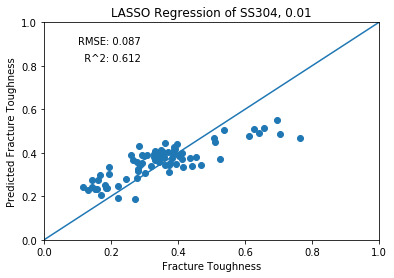

<Figure size 432x288 with 0 Axes>

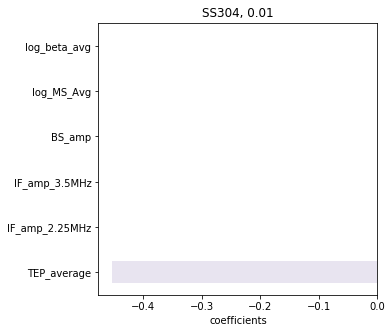

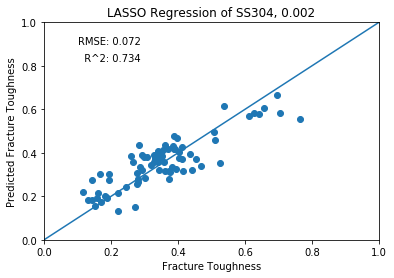

<Figure size 432x288 with 0 Axes>

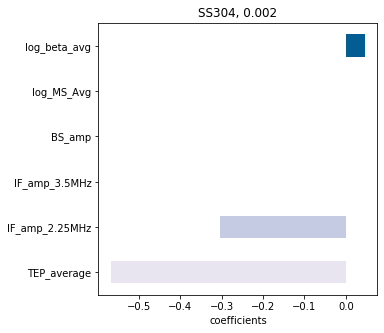

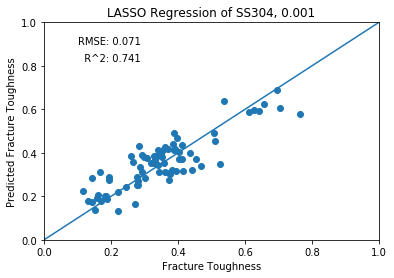

<Figure size 432x288 with 0 Axes>

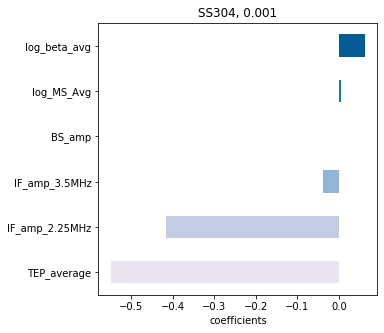

In [40]:
for alpha in [0.01, 0.002, 0.001]:
    lasso_sstype(SS_304,"SS304", alpha)


SS316, 0.01
Training dataset: (185, 6)
Test dataset: (80, 6)

RMSE train: 0.1067000718815033
r2 score for train:  0.11565946453681919
RMSE test: 0.1259303123885465
r2 score for test:  0.03214986891424487
SS316, 0.002
Training dataset: (185, 6)
Test dataset: (80, 6)

RMSE train: 0.07362527987421635
r2 score for train:  0.5789399617336615
RMSE test: 0.08571398227461358
r2 score for test:  0.5516151836655814
SS316, 0.001
Training dataset: (185, 6)
Test dataset: (80, 6)

RMSE train: 0.0668936289240973
r2 score for train:  0.6524161241785538
RMSE test: 0.07824798664245916
r2 score for test:  0.6263251272039321


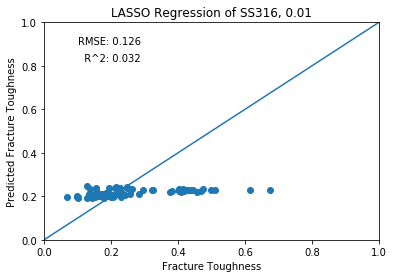

<Figure size 432x288 with 0 Axes>

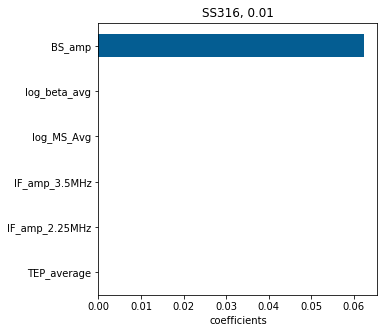

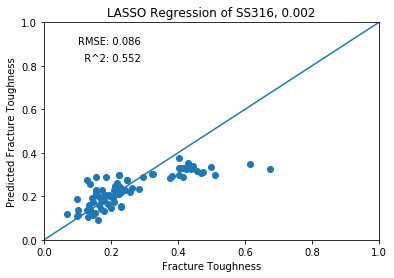

<Figure size 432x288 with 0 Axes>

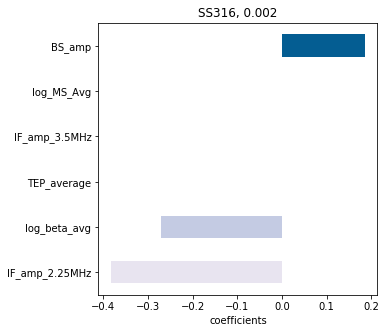

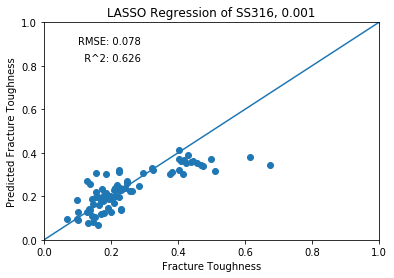

<Figure size 432x288 with 0 Axes>

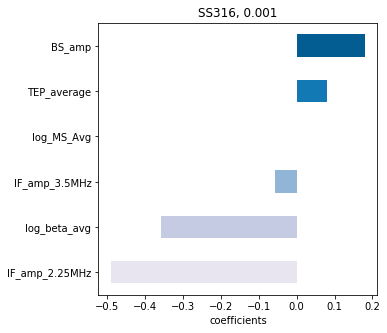

In [41]:
for alpha in [0.01, 0.002, 0.001]:
    lasso_sstype(SS_316,"SS316", alpha)


SS347, 0.01
Training dataset: (181, 6)
Test dataset: (78, 6)

RMSE train: 0.10441112629809843
r2 score for train:  0.8281891116773253
RMSE test: 0.1037670449607239
r2 score for test:  0.8461846084519515
SS347, 0.002
Training dataset: (181, 6)
Test dataset: (78, 6)

RMSE train: 0.08060523352661743
r2 score for train:  0.8976038558185082
RMSE test: 0.07730779352902492
r2 score for test:  0.914625641574385
SS347, 0.001
Training dataset: (181, 6)
Test dataset: (78, 6)

RMSE train: 0.0744041511287168
r2 score for train:  0.9127528087600232
RMSE test: 0.07159983957834766
r2 score for test:  0.9267673085896627


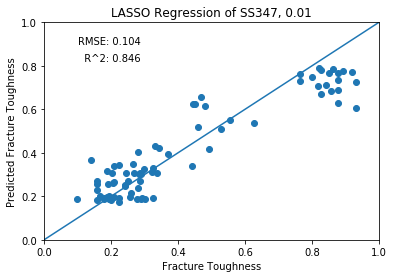

<Figure size 432x288 with 0 Axes>

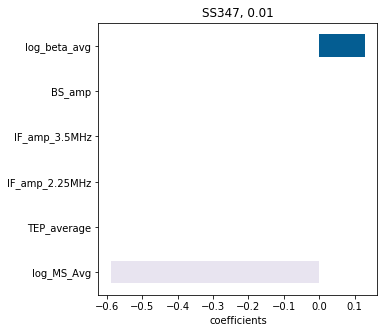

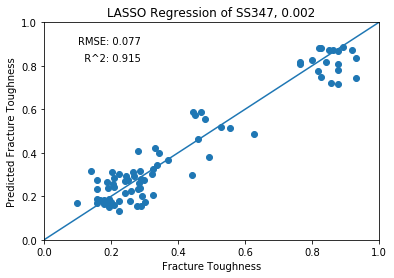

<Figure size 432x288 with 0 Axes>

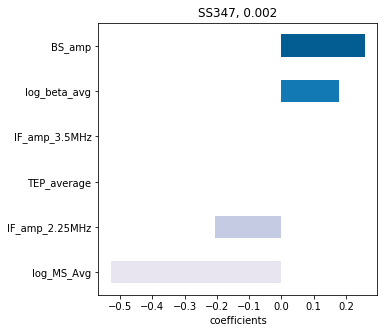

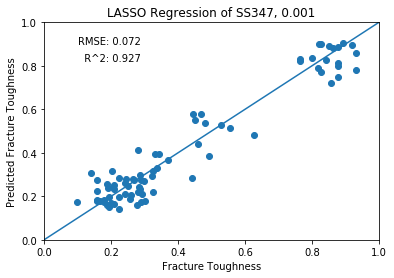

<Figure size 432x288 with 0 Axes>

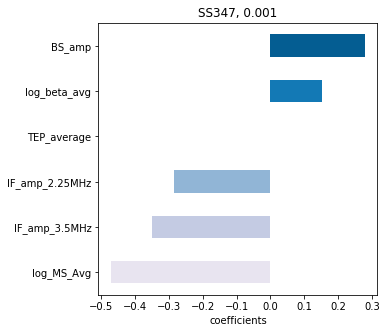

In [42]:
for alpha in [0.01, 0.002, 0.001]:
    lasso_sstype(SS_347,"SS347", alpha)
